# 手撸Transformer并摘引原文注解
#### 论文: 
+ [Attention Is All You Need](./Attention%20is%20all%20you%20need.pdf),arXiv:1706.03762v5 [cs.CL] 6 Dec 2017, 31st Conference on Neural Information Processing Systems (NIPS 2017), Long Beach, CA, USA.

#### 参考:
* http://nlp.seas.harvard.edu/2018/04/03/attention.html
* https://github.com/harvardnlp/annotated-transformer
* https://jalammar.github.io/illustrated-transformer/
* https://www.mihaileric.com/posts/transformers-attention-in-disguise/
* https://github.com/bentrevett/pytorch-seq2seq

#### 运行环境: Colab GPU

# Colab环境需要的依赖包和数据

In [1]:
# !pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

     |████████████████████████████████| 47 kB 2.0 MB/s 
     |████████████████████████████████| 6.0 MB 5.1 MB/s 
     |████████████████████████████████| 138 kB 48.4 MB/s 
     |████████████████████████████████| 457 kB 51.0 MB/s 
     |████████████████████████████████| 653 kB 47.5 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 10.1 MB 38.4 MB/s 
     |████████████████████████████████| 181 kB 55.1 MB/s 
     |████████████████████████████████| 58 kB 4.3 MB/s 
     |████████████████████████████████| 127 kB 13.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 19.1 MB 670 kB/s 
✔ Downlo

# Part 1: Transformer Implementation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math, copy, time
import matplotlib.pyplot as plt
import seaborn

from torch.autograd import Variable
from IPython.display import Image

seaborn.set_context(context='talk')
%matplotlib inline

In [2]:
model_path = "../pt/multi30k_model_final.pt"  # Local
vocab_path = "../pt/vocab.pt"  # Local
if torch.cuda.is_available():
  model_path = "multi30k_model_final.pt"  # Colab
  vocab_path = "vocab.pt"  # Colab

## Background
Self-attention, sometimes called intra-attention, is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence.
End-to-end memory networks are based on attention mechanism instead of sequence aligned recurrence and have been shown to perform well on simple-language QA and language modeling tasks.

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. 
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequence."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Stacks
The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.


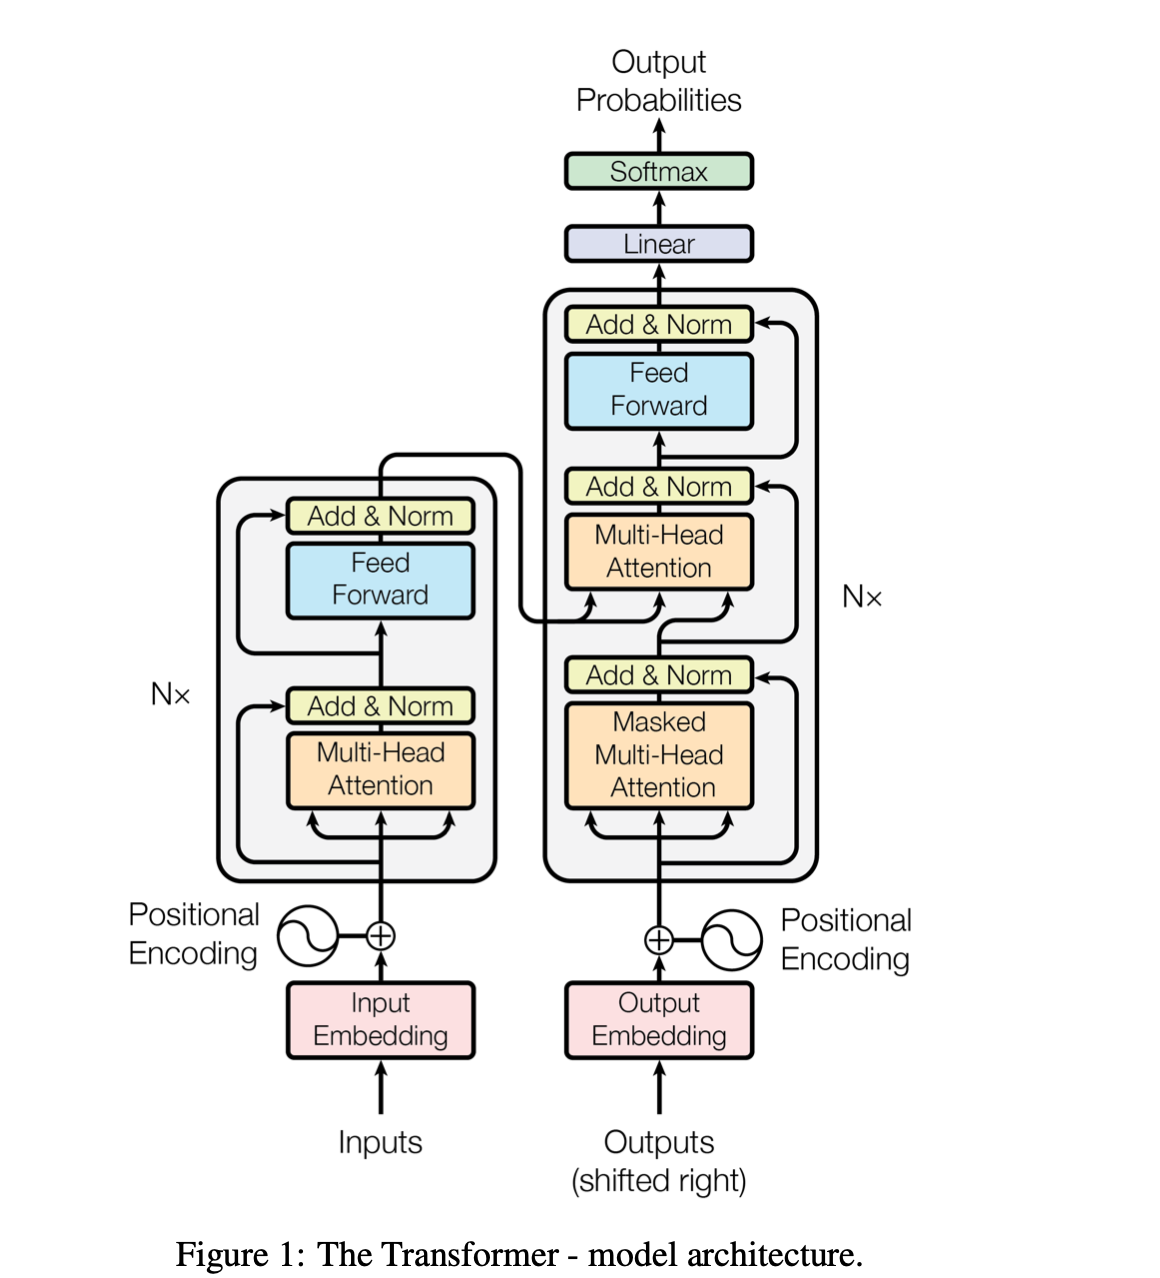

In [ ]:
Image(filename='images/transformer-model.png')

## Encoder
The encoder is composed of a stack of N=6 identical layers.

In [5]:
def clones(module, N):
    """
    Produce N identical layers.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

We employ a residual connection around each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself.

In [6]:
class LayerNorm(nn.Module):
    """
    Construct a layernorm module.
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        
        return self.a_2 * (x - mean)/(std + self.eps) + self.b_2

In [7]:
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        # print(f'Encoder layer.size={layer.size}')
    
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        
        return self.norm(x)

The output of each sub-layer is LayerNorm(x+Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.
To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model}=512$.

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [9]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attention and feed forward (defined below)
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        """
        Follow Figure 1 (left) for connections.
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

## Decoder
The decoder is also composed of a stack of N=6 identical layers.

In [11]:
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        # print(f'Decoder layer.size={layer.size}')
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [12]:
class DecoderLayer(nn.Module):
    """
    Decoder is made up of self-attention, src-attention and feed forward (defined below)
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Follow Figure 1 (right) for connections.
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position 
i can depend only on the known outputs at positions less than i.

In [13]:
# def subsequent_mask(size):
#     """
#     Mask out subsequent positions.
#     """
#     attn_shape = (1, size, size)
#     subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
#     return torch.from_numpy(subsequent_mask) == 0

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])


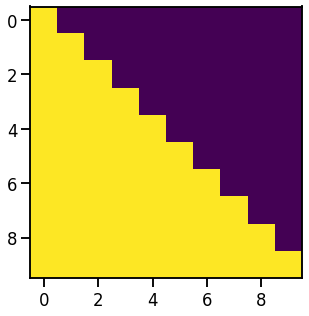

In [14]:
# Below the attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training.
print(subsequent_mask(10)[0])
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(10)[0])
None

## Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.


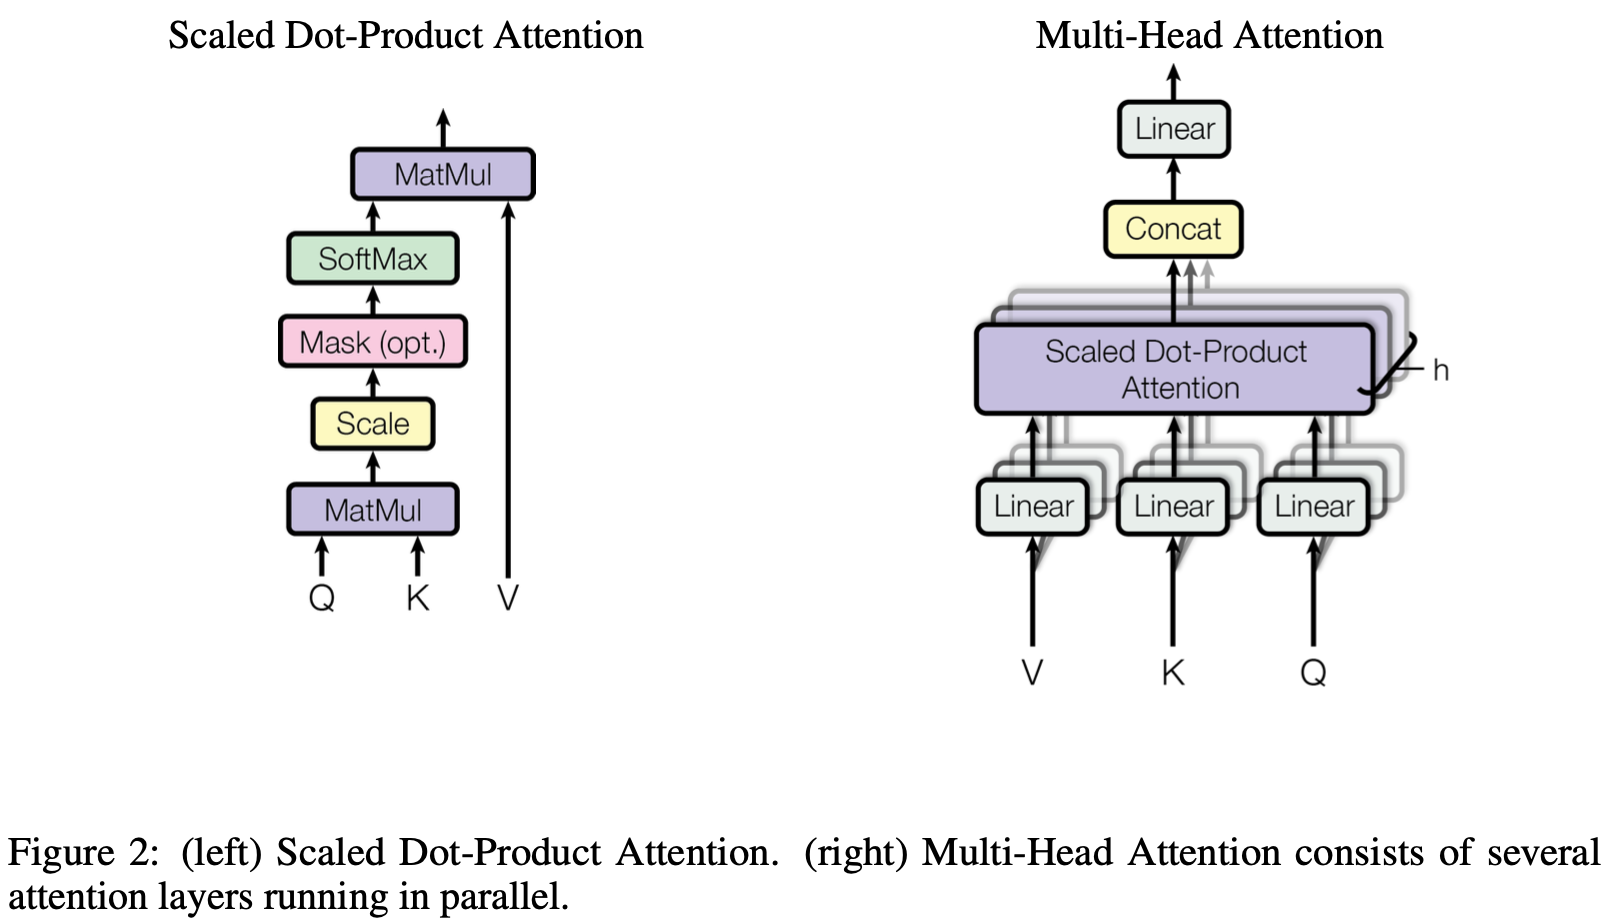

In [ ]:
Image(filename='images/attention.png')

$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$

In [15]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Compute 'Scaled Dot-Product Attention', 
    Implements Figure 2: (left)
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.
$$MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O$$

where $$head_i = Attention(QW^Q_i, KW^K_i, VW^V_i)$$

Where the projections are parameter matrics $W^Q_i\in R^{d_{model}*d_Q}$, $W^K_i\in R^{d_{model}*d_K}$, $W^V_i\in R^{d_{model}*d_V}$, and $W^O\in R^{hd_v*d_{model}}$. 

In this work we employ h=8 parallel attention layers, or heads. For each of these we use $d_k=d_v=\frac{d_{model}}{h}=64$. Due to the reduced dimension of each head, the head, the total computational cost is similar to that of single-head attention with full dimensionality.

In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        """
        Implements Figure 2 (right).
        """
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
            for l, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        del query
        del key
        del value

        return self.linears[-1](x)

## Applications of Attention in our Model
The Transformer uses multi-head attention in three different ways:
+ In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence.
+ The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.
+ Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out (setting to −∞) all values in the input of the softmax which correspond to illegal connections.


## Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$FFN(x)=max(0, xW_1 + b_1)W_2 + b_2$$

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is $d_{model} = 512$, and the inner-layer has dimensionality $d_{ff} =2048$.

In [17]:
# class PositionwiseFeedForward(nn.Module):
#     """
#     Implements FFN equation.
#     """
#     def __init__(self, d_model, d_ff, dropout=0.1):
#         super(PositionwiseFeedForward, self).__init__()
#         self.w_1 = nn.Linear(d_model, d_ff)
#         self.w_2 = nn.Linear(d_ff, d_model)
#         self.dropout = nn.Dropout(dropout)
    
#     def forward(self, x):
#         return self.w_2(self.dropout(F.relu(self.w_1(x))))

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## Embedding and Softmax
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{model}$. We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{model}}$.

In [18]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding
We add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks. The positional encodings have the same dimension $d_{model}$ as the embeddings, so that the two can be summed. There are many choices of positional encodings, learned and fixed. In this work, we use sine and cosine functions of different frequencies:
$$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$$
where pos is the position and i is the dimension. That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In [19]:
# class PositionalEncoding(nn.Module):
#     """
#     Implement the PE function.
#     """
#     def __init__(self, d_model, dropout, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
        
#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)
        
#     def forward(self, x):
#         x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

#         return self.dropout(x)
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

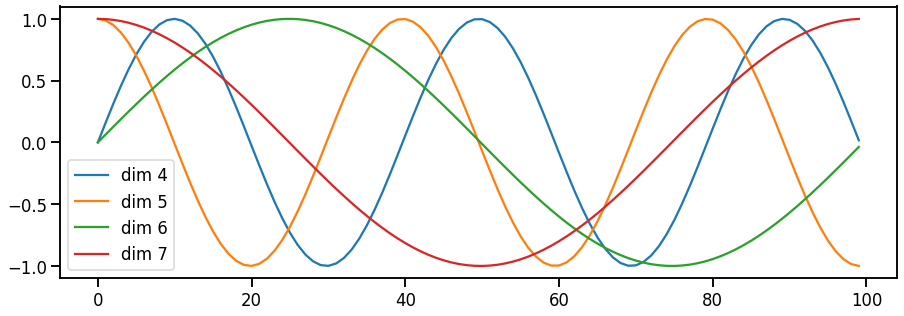

In [20]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
#print(y.shape)
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(['dim %d' %p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

## Full Model

In [21]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
    Helper: Construct a model from hyperparameters.
    """
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## Inference Test
Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next tutorial we will build the training function and try to train our model to memorize the numbers from 1 to 10.

In [22]:
# Some convenience helper functions
RUN_EXAMPLES = True

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

In [23]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 5, 5, 5, 5, 5, 5, 5, 5, 5]])
Example Untrained Model Prediction: tensor([[ 0, 10,  3,  3,  3,  2,  9,  2,  9,  2]])
Example Untrained Model Prediction: tensor([[0, 1, 3, 4, 9, 3, 4, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 8, 7, 9, 9, 9, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[ 0,  2, 10,  0,  0,  0,  5,  8,  8,  8]])
Example Untrained Model Prediction: tensor([[0, 8, 8, 9, 1, 9, 1, 9, 1, 9]])
Example Untrained Model Prediction: tensor([[ 0,  9, 10,  2,  1,  2,  1,  2,  1,  2]])
Example Untrained Model Prediction: tensor([[0, 2, 1, 1, 4, 8, 4, 8, 4, 8]])
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 8, 3, 8, 3, 8, 3]])


In [24]:
tmp_model = make_model(10, 10, 2)
None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Part 2 Training And Applying

In [25]:
from torch.optim.lr_scheduler import LambdaLR
import altair as alt
import pandas as pd
import warnings

# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

Below the positional encoding will add in a sine wave based on position. The frequency and offset of the wave is different for each dimension.

In [26]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [27]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [28]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

In [29]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [30]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

In [31]:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data

In [32]:
def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)

alt.Chart(...)

In [33]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

In [34]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

In [35]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

# Part 3 A Real World Example
>Now we consider a real-world example using the Multi30k German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.


In [36]:
# Some convenience helper functions

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

## Data Loading
>We will load the dataset using torchtext and spacy for tokenization.

In [37]:
# Load spacy tokenizer models, download them if they haven't been
# downloaded already
import spacy
import os
from torchtext import data, datasets
from torchtext.vocab import build_vocab_from_iterator

In [38]:
def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [39]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [40]:
# Some convenience helper functions


def is_interactive_notebook():
    return __name__ == "__main__"


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


In [41]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not os.path.exists(vocab_path):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), vocab_path)
    else:
        vocab_src, vocab_tgt = torch.load(vocab_path)
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

Building German Vocabulary ...
Building English Vocabulary ...
Finished.
Vocabulary sizes:
8315
6384


## Iterator

In [42]:
from torch.nn.functional import pad

def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [43]:
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

### Training the System

In [44]:
import GPUtil
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP


def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [45]:
import torch.multiprocessing as mp


def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }

    if not os.path.exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    return model


if is_interactive_notebook():
    model = load_trained_model()

Train worker process using GPU: 0 for training
[GPU0] Epoch 0 Training ====
Epoch Step:      1 | Accumulation Step:   1 | Loss:   7.57 | Tokens / Sec:   921.4 | Learning Rate: 5.4e-07
Epoch Step:     41 | Accumulation Step:   5 | Loss:   7.36 | Tokens / Sec:   883.6 | Learning Rate: 1.1e-05
Epoch Step:     81 | Accumulation Step:   9 | Loss:   6.99 | Tokens / Sec:   880.5 | Learning Rate: 2.2e-05
Epoch Step:    121 | Accumulation Step:  13 | Loss:   6.72 | Tokens / Sec:   862.1 | Learning Rate: 3.3e-05
Epoch Step:    161 | Accumulation Step:  17 | Loss:   6.52 | Tokens / Sec:   857.1 | Learning Rate: 4.4e-05
Epoch Step:    201 | Accumulation Step:  21 | Loss:   6.40 | Tokens / Sec:   867.3 | Learning Rate: 5.4e-05
Epoch Step:    241 | Accumulation Step:  25 | Loss:   6.14 | Tokens / Sec:   868.5 | Learning Rate: 6.5e-05
Epoch Step:    281 | Accumulation Step:  29 | Loss:   6.04 | Tokens / Sec:   860.2 | Learning Rate: 7.6e-05
Epoch Step:    321 | Accumulation Step:  33 | Loss:   5.77 |

Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate.

# Results

In [46]:
# Load data and model for output checks
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load(model_path, map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


execute_example(run_model_example)

Preparing Data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Ein Mann mit Anzug und Brille hält einen Gegenstand in den Händen . </s>
Target Text (Ground Truth) : <s> A man in a suit and glass has an object in his hands . </s>
Model Output               : <s> A man wearing a suit and glasses holds an object in his hands . </s>

Example 1 ========

Source Text (Input)        : <s> Vier Menschen versuchen in einem Park , ein Fahrrad zu reparieren </s>
Target Text (Ground Truth) : <s> 4 people trying to fix a bike on a park </s>
Model Output               : <s> Four people trying to fix a bike in a park . </s>

Example 2 ========

Source Text (Input)        : <s> Ein Junge in einem orangen T-Shirt lächelt , während ihn ein Junge in einem blauen T-Shirt ansieht . </s>
Target Text (Ground Truth) : <s> A boy with an orange shirt smiles , while a boy in a blue shirt looks on . </s>
Model Output               : <s> A boy in an orang

# Attention Visualization
Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention.

In [47]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        # if float(m[r,c]) != 0 and r < max_row and c < max_col],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [48]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    # ntokens = last_example[0].ntokens
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

## Encoder Self Attention

In [49]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

Preparing Data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Ein einzelner Feuerwehrmann hilft bei der <unk> eines großen <unk> . </s>
Target Text (Ground Truth) : <s> A lone firefighter helps tame a large fire . </s>
Model Output               : <s> A lone fireman helping the <unk> of a large <unk> . </s>


alt.HConcatChart(...)

## Decoder Self Attention

In [50]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

Preparing Data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> <unk> in blau-weißer Spielkleidung befinden sich auf dem Spielfeld und spielen Baseball . </s>
Target Text (Ground Truth) : <s> <unk> in blue and white uniforms are on the field playing baseball . </s>
Model Output               : <s> <unk> <unk> in blue and white uniforms playing baseball . </s>


alt.HConcatChart(...)

## Decoder Src Attention

In [51]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)

Preparing Data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Da ist eine Frau , die mit einem Fahrrad die Straße entlangfährt und dabei nur auf dem Hinterrad fährt . </s>
Target Text (Ground Truth) : <s> There is a woman riding a bike down the road , and she <unk> a wheelie . </s>
Model Output               : <s> There is a woman on a bike riding down the street with a bike in a bike . </s>


alt.HConcatChart(...)

# Conclusion
Hopefully this code is useful for work or future research. 